# Fictional Employee Data

### Imports

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import random as rand
import datetime as dt
from dateutil.relativedelta import relativedelta as rd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
#!pip install Faker
from faker import Faker
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix


### Functions

In [2]:
# creates list of birthdate datetime objects based off age
def birthDate(age, date=None):
  if date == None:
    date = dt.datetime.now()
  return [date - rd(years=x,months=rand.randint(-12, 12),days=rand.randint(-31,31)) for x in age]

# creates list with multiple modes
def multimodallist(obs,stdperlist,modes):
    if obs<len(modes):
        raise Exception('obs is less than amount of modes')
    remainder = obs%len(modes)
    listSize =int((obs - remainder)/len(modes))
    multimodal = []
    # combines smaller lists with different modes to equal list with obs observations
    for i in modes:
        multimodal+=np.random.normal(i,stdperlist,listSize).astype(int).tolist()
    if remainder >0:
        multimodal+=np.random.normal(np.mean(multimodal),stdperlist,remainder).astype(int).tolist()
    return multimodal
def probablity_generator(length):
    return [1/length]*length
def ml_data(newColumn,std,mean):
    random = np.random.normal(mean,std,len(newColumn))
    return newColumn + random


### Data Dictionary

In [45]:
np.random.seed(101)
obs = 10000
fake = Faker()
Faker.seed(2)
# age = np.random.normal(50,6,obs).astype(int)
multimodalage = multimodallist(obs,5,[33,45,65])
mbti = ['ISTJ','ISFJ','INFJ','INTJ','ISTP','ISFP','INFP','INTP','ESTP','ESFP','ENFP','ENTP','ESTJ','ESFJ','ENFJ','ENTJ']
percentage = [0.116,0.138,0.015,0.021,0.054,0.088,0.044,0.033,0.043,0.085,0.081,0.032,0.087,0.12,0.025,0.018]
multiplier = ((1-np.array(percentage))*2)**2
mbtimultiplier = {}

for i in range(0,len(mbti)):
    mbtimultiplier[mbti[i]] = multiplier[i]

name = set()
while len(name) < obs:
    name.add(fake.name())
address = set()
while len(address) < obs:
    address.add(fake.address())
performance = ['1','2','3','4','5']

data = {'id':list(range(100000,100000+obs)),
        'age': multimodalage,
        'birthDate': birthDate(multimodalage,date=dt.datetime(2023,9,30)),
        'mbti': np.random.choice(mbti,size=obs,p=percentage),
        'name': list(name),
        'address':list(address),
        'performance':np.random.choice(performance,size=obs,p=[0.1,0.1,0.3,0.3,0.2])
        }
df = pd.DataFrame(data)
df['multiplier'] = [mbtimultiplier[x] for x in df['mbti']]
df['score'] = ml_data(((df['age']**2)/100 + df['age']/10 + 20),5,0).apply(lambda x: round(x,2))
df['salary'] = ml_data((df['score']*1000+20000*df['multiplier']),10000,0).apply(lambda x: round(x,2))
df['years_worked'] = ml_data(df['age']/30,1,5).apply(lambda x: round(x,2))
df['401k_total'] = (df['salary']*0.05 * df['years_worked']).apply(lambda x: round(x,2))

In [46]:
df.head()

,id,age,birthDate,mbti,name,address,performance,multiplier,score,salary,years_worked,401k_total
0,100000,46,1978-01-15,ISTP,Jessica Donovan,"835 Sandra Viaduct\nJohnsonfurt, MS 23284",4,3.579664,44.71,112815.87,6.01,33901.17
1,100001,36,1988-06-12,ESFP,Nancy Scott,USS Barnett\nFPO AA 79275,3,3.348900,37.43,105541.80,5.29,27915.81
2,100002,37,1986-03-31,ISFJ,Timothy May,"0534 Tran Prairie\nPort David, AZ 18481",3,2.972176,44.82,106715.28,8.00,42686.11
3,100003,35,1988-03-22,ENFP,James Shaw,"09239 Amanda Court\nNorth Larry, VT 55190",4,3.378244,29.82,90296.30,5.87,26501.96
4,100004,36,1986-10-12,ESFJ,Logan Diaz,"22572 Ramos Ramp\nEast Ashley, ID 76181",1,3.097600,33.60,102211.16,4.62,23610.78


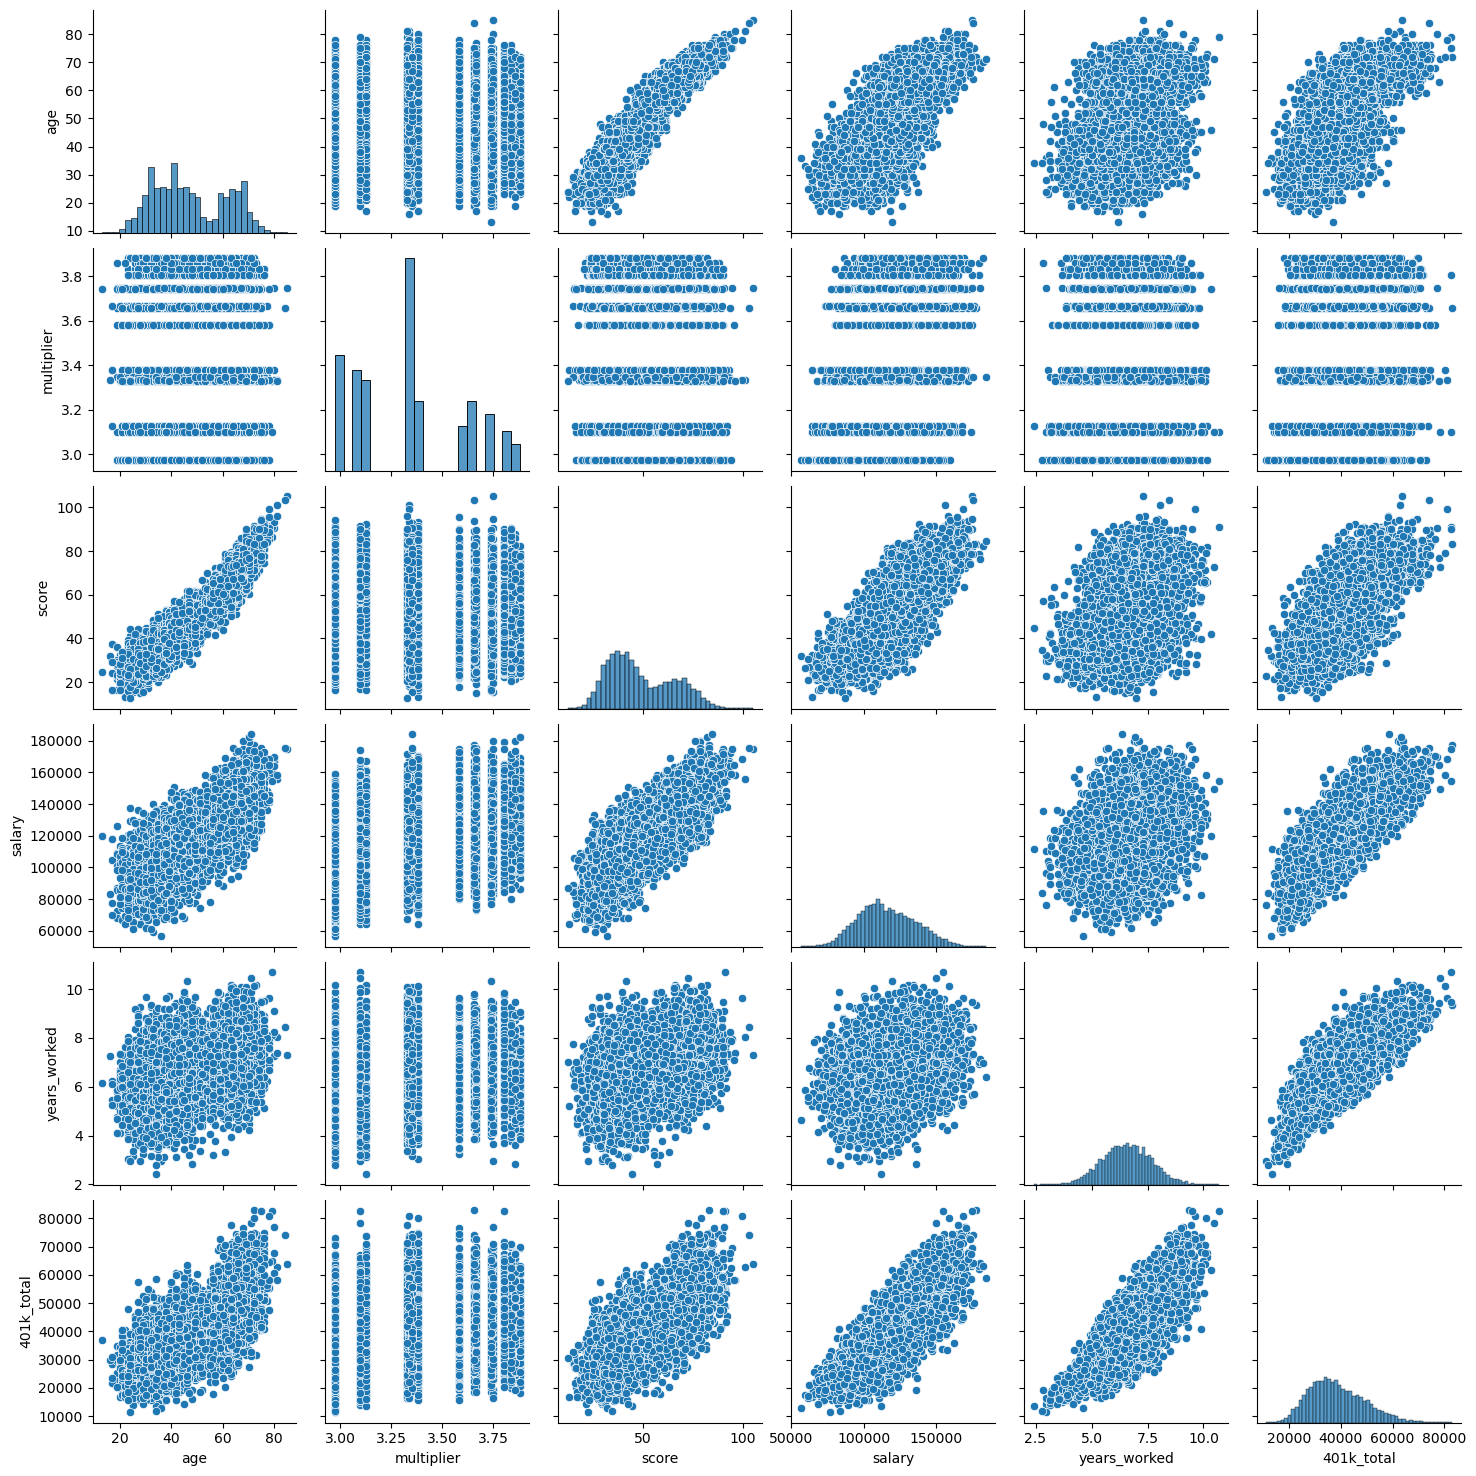

In [47]:
sns.pairplot(df.drop('id',axis=1))

<Axes: xlabel='score', ylabel='salary'>

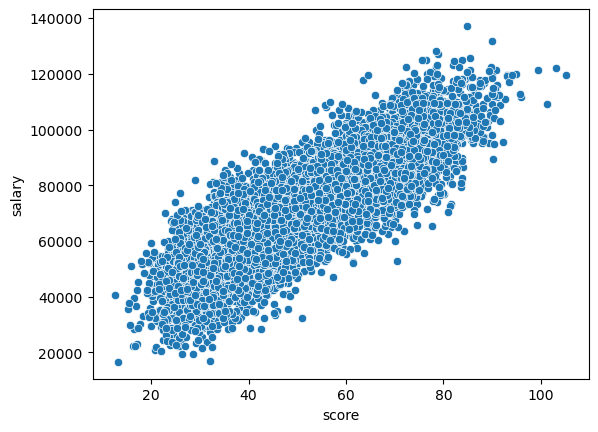

In [6]:
sns.scatterplot(data=df, y='salary', x='score')

# Machine Learning

In [48]:
data = df[['age','score']]
train, test = train_test_split(
    data, test_size=0.2, random_state=42)

model = smf.ols(
  formula='score ~ age + I(age**2)', data=train).fit()

ols_results_summary = model.summary()

print(ols_results_summary)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 3.766e+04
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:49:25   Log-Likelihood:                -24166.
No. Observations:                8000   AIC:                         4.834e+04
Df Residuals:                    7997   BIC:                         4.836e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      20.4820      0.706     29.012      

<Axes: xlabel='age', ylabel='score'>

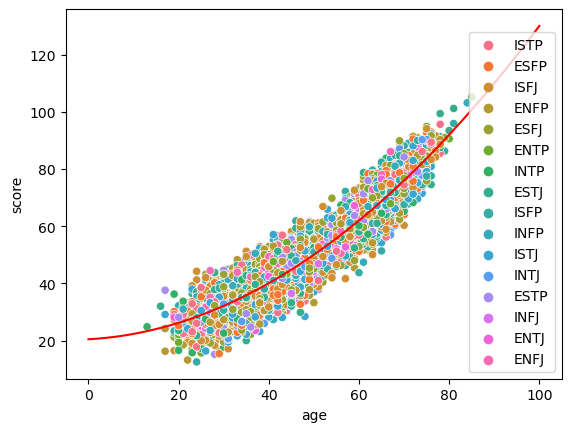

In [49]:
age = pd.DataFrame({'age':np.linspace(0,100,1000)})

score = model.predict(age)

sns.scatterplot(x='age',y='score', data=df, hue='mbti')
sns.lineplot(y=score, x=age['age'],  color='red')

In [50]:
X = df[['salary','score']]
scaler = StandardScaler()
scaled = scaler.fit(X)
X_scaled = scaler.transform(X)
y = df['mbti']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

In [51]:
print(classification_report(y_test,y_pred,zero_division=0.0))

              precision    recall  f1-score   support

        ENFJ       0.09      0.08      0.09        83
        ENFP       0.08      0.11      0.10       284
        ENTJ       0.00      0.00      0.00        63
        ENTP       0.05      0.04      0.04       104
        ESFJ       0.12      0.17      0.14       423
        ESFP       0.08      0.07      0.07       282
        ESTJ       0.13      0.08      0.10       294
        ESTP       0.09      0.05      0.06       138
        INFJ       0.00      0.00      0.00        43
        INFP       0.06      0.02      0.03       136
        INTJ       0.00      0.00      0.00        76
        INTP       0.10      0.05      0.06       130
        ISFJ       0.25      0.50      0.33       456
        ISFP       0.07      0.06      0.06       289
        ISTJ       0.09      0.09      0.09       332
        ISTP       0.06      0.03      0.04       167

    accuracy                           0.14      3300
   macro avg       0.08   

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [55]:
print(classification_report(y_test,y_pred,zero_division=0.0))

              precision    recall  f1-score   support

        ENFJ       0.07      0.10      0.08        83
        ENFP       0.09      0.10      0.10       284
        ENTJ       0.02      0.02      0.02        63
        ENTP       0.03      0.03      0.03       104
        ESFJ       0.15      0.17      0.16       423
        ESFP       0.09      0.09      0.09       282
        ESTJ       0.11      0.11      0.11       294
        ESTP       0.07      0.07      0.07       138
        INFJ       0.02      0.02      0.02        43
        INFP       0.04      0.04      0.04       136
        INTJ       0.06      0.04      0.05        76
        INTP       0.08      0.05      0.06       130
        ISFJ       0.20      0.21      0.20       456
        ISFP       0.09      0.08      0.08       289
        ISTJ       0.09      0.09      0.09       332
        ISTP       0.04      0.03      0.03       167

    accuracy                           0.11      3300
   macro avg       0.08   

### Data Visualization

count    10000.000000
mean        47.240000
std         14.106633
min         13.000000
25%         36.000000
50%         45.000000
75%         61.000000
max         85.000000
Name: age, dtype: float64
Axes(0.125,0.11;0.775x0.77)


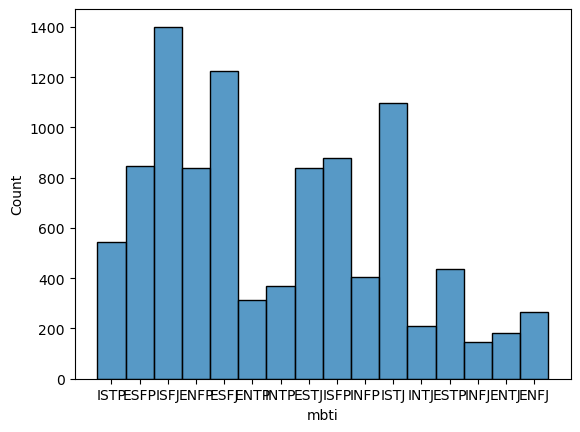

In [9]:
print(df['age'].describe())
print(sns.histplot(df['mbti']))

Axes(0.125,0.11;0.775x0.77)


,id,age,birthDate,mbti,name,address,performance,score,salary,years_worked,401k_total
2851,102851,34,1989-02-22,ISTJ,Cody Salinas,"4852 Sanders Underpass\nLake Melissa, AK 97543",4,31.92,49460.77,5.22,12909.26
779,100779,48,1976-08-19,ISTJ,Ashley Berry,"PSC 0392, Box 1959\nAPO AA 98216",4,50.05,62743.80,8.09,25379.87
1641,101641,43,1981-10-03,ESFJ,Jennifer Hatfield,"52197 Moore Ridges\nMitchellmouth, LA 66015",5,52.29,59115.74,7.88,23291.60
5584,105584,41,1982-01-02,INTJ,Brooke Smith,"27394 Russell Dale\nPort Jonathanstad, OR 32423",4,37.45,63258.61,5.26,16637.01
7712,107712,71,1952-08-27,INFP,Alexandra Reynolds,"2136 Williams Pike\nGarzamouth, TX 32833",4,75.42,76047.73,8.08,30723.28


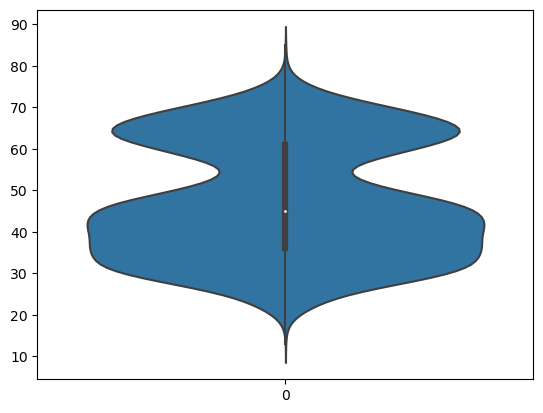

In [10]:
print(sns.violinplot(df['age']))
df.sample(5)

In [11]:
# Check type() of birthData column
type(df['birthDate'][0])

pandas._libs.tslibs.timestamps.Timestamp

<Axes: xlabel='age', ylabel='mbti'>

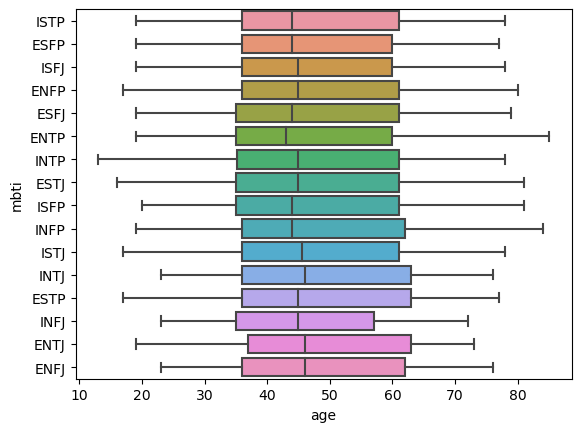

In [12]:
sns.boxplot(y='mbti', x='age', data=df)